<a href="https://www.kaggle.com/gautammdiwan/linear-regresssion-using-rapids?scriptVersionId=88928967" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
from IPython.display import clear_output

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split,GridSearchCV

In [4]:
import cudf as cd
import cupy as cp
from cuml.preprocessing.LabelEncoder import LabelEncoder
# from cuml.experimental.preprocessing import StandardScaler
from cuml import PCA,Ridge,LinearRegression,Lasso,ElasticNet
from cuml.model_selection import train_test_split
from cuml.metrics.regression import mean_squared_error,mean_absolute_error,r2_score

In [5]:
df_train = cd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df_test = cd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,<NA>,Reg,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,<NA>,Reg,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,<NA>,IR1,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,<NA>,IR1,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,<NA>,IR1,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,<NA>,Reg,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,<NA>,Reg,Lvl,AllPub,...,0,<NA>,MnPrv,<NA>,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,<NA>,Reg,Lvl,AllPub,...,0,<NA>,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,<NA>,Reg,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,4,2010,WD,Normal,142125


In [6]:
df_test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,<NA>,Reg,Lvl,AllPub,...,120,0,<NA>,MnPrv,<NA>,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,<NA>,IR1,Lvl,AllPub,...,0,0,<NA>,<NA>,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,<NA>,IR1,Lvl,AllPub,...,0,0,<NA>,MnPrv,<NA>,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,<NA>,IR1,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,<NA>,IR1,HLS,AllPub,...,144,0,<NA>,<NA>,<NA>,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,MnPrv,Shed,700,7,2006,WD,Normal


In [7]:
df_train.shape,df_test.shape

((1460, 81), (1459, 80))

In [8]:
df=cd.concat([df_train.iloc[:,:-1],df_test]).reset_index(drop=True)
Y=df_train.iloc[:,-1].copy()
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,<NA>,IR1,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,<NA>,IR1,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,<NA>,IR1,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,6,2006,WD,Normal
2915,2916,160,RM,21.0,1894,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,4,2006,WD,Abnorml
2916,2917,20,RL,160.0,20000,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,<NA>,<NA>,0,9,2006,WD,Abnorml
2917,2918,85,RL,62.0,10441,Pave,<NA>,Reg,Lvl,AllPub,...,0,0,<NA>,MnPrv,Shed,700,7,2006,WD,Normal


## Below function will be used to preprocess the test dataframe

In [9]:
def preprocess_df(df,cols=1):
    if cols >0: 
        X = df.copy()
        pca = PCA(n_components=cols,output_type='cudf')
        pca.fit(X)
        df1=pca.transform(X)
        X=df1
        del df1
    else:
        X=df
    del df
        
    return X
        

# **HANDLING MISSING VALUES**

### DROPPING COLUMNS WHICH HAVE MORE 20% OF THEIR VALUES AS NAN
#### ID is also dropped since it is just a range series

In [10]:
na_cols=[]
for col in df.columns:
    if df[col].isna().sum() > 0.2*len(df):
        na_cols.append(col)
df=df.drop(na_cols,axis=1)

na_cols=[]
for col in df.select_dtypes(exclude='object').columns:
    if (df[col]==0).sum() > 0.2*len(df):
        na_cols.append(col)
df=df.drop(na_cols,axis=1)
df=df.drop('Id',axis=1)
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,RFn,2.0,548.0,TA,TA,Y,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,RFn,2.0,460.0,TA,TA,Y,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,RFn,2.0,608.0,TA,TA,Y,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,Unf,3.0,642.0,TA,TA,Y,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,RFn,3.0,836.0,TA,TA,Y,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,<NA>,0.0,0.0,<NA>,<NA>,Y,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,Unf,1.0,286.0,TA,TA,Y,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,Unf,2.0,576.0,TA,TA,Y,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,<NA>,0.0,0.0,<NA>,<NA>,Y,7,2006,WD,Normal


## FILLING REMAINING NAN VALUES
#### CATEGORICAL FEATURES ARE REPLACED WITH THEIR MODE VALUE
#### NUMERICAL FEATURES ARE REPLACED WITH THEIR MEAN VALUE

In [11]:
for col in df.select_dtypes(include='object').columns:
    df[col]=df[col].fillna(df[col].mode()[0],inplace=False)
    
for col in df.select_dtypes(exclude='object').columns:
    df[col]=df[col].fillna(df[col].mean(),inplace=False)

**SPLITTING THE DATA**

In [12]:
df_train=df.iloc[:1460,:]
df_train['SalePrice']=Y
df_test = df.iloc[1460:,:]
df_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,2.0,548.0,TA,TA,Y,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,2.0,460.0,TA,TA,Y,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,2.0,608.0,TA,TA,Y,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,3.0,642.0,TA,TA,Y,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,3.0,836.0,TA,TA,Y,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,2.0,460.0,TA,TA,Y,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,2.0,500.0,TA,TA,Y,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,1.0,252.0,TA,TA,Y,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,1.0,240.0,TA,TA,Y,4,2010,WD,Normal,142125


**CHECKING THE DISTRIBUTION OF RANGE OF POSSIBLE VALUES FOR EACH COLUMN**

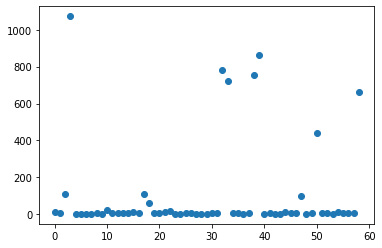

In [13]:
plt.scatter(range(df_train.shape[1]),[df_train[col].nunique() for col in df_train.columns])

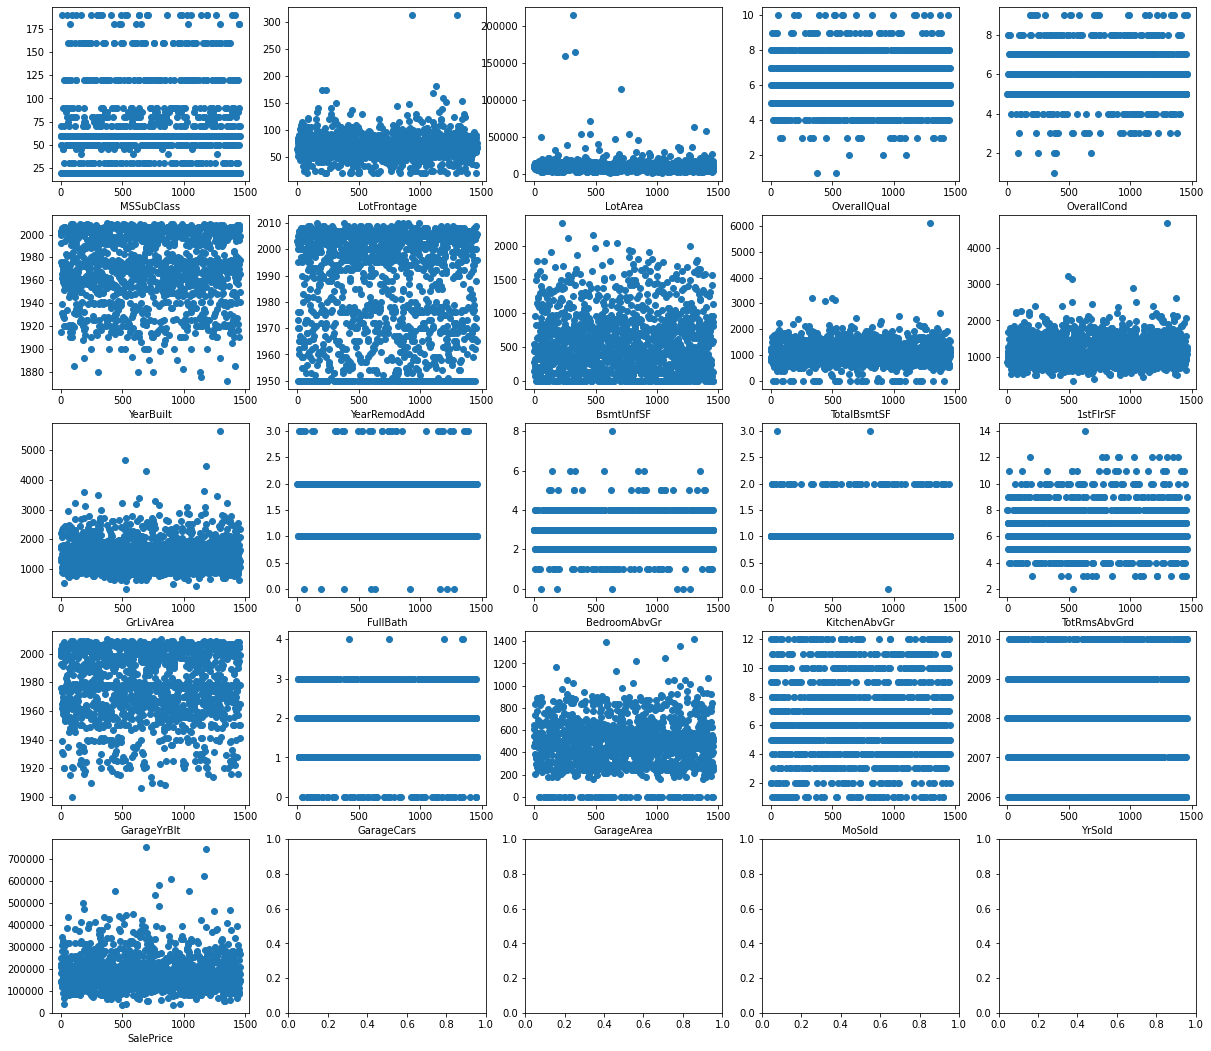

In [14]:
plots=len([col for col in df_train.select_dtypes(exclude='object').columns])
fig,ax = plt.subplots(int(cp.sqrt(plots)+1),int(cp.sqrt(plots)+1))
fig.set_size_inches(20.5, 18.5)
j=[i for i in cp.arange(int(cp.sqrt(plots)+1)).get() for j in cp.arange(int(cp.sqrt(plots)+1)).get()]
k=[j for i in cp.arange(int(cp.sqrt(plots)+1)).get() for j in cp.arange(int(cp.sqrt(plots)+1)).get()]
# ax.shape
for idx,col in enumerate(df_train.select_dtypes(exclude='object').columns):
#     print(k[idx],j[idx],type(k[idx]),type(j[idx]))
    ax[j[idx]][k[idx]].scatter(x=range(len(df_train)),y=df_train[col].to_array())
    ax[j[idx]][k[idx]].set_xlabel(col)

## ENCODING THE CATEGORICAL FEATURES WITH LABEL ENCODER

In [15]:
for col in df.select_dtypes(include='object').columns:
    enc=LabelEncoder()
    df[col]=cd.Series(enc.fit_transform(df[col]))
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,3,3,0,4,0,...,1,2.0,548.0,4,4,2,2,2008,8,4
1,20,3,80.0,9600,1,3,3,0,2,0,...,1,2.0,460.0,4,4,2,5,2007,8,4
2,60,3,68.0,11250,1,0,3,0,4,0,...,1,2.0,608.0,4,4,2,9,2008,8,4
3,70,3,60.0,9550,1,0,3,0,0,0,...,2,3.0,642.0,4,4,2,2,2006,8,0
4,60,3,84.0,14260,1,0,3,0,2,0,...,1,3.0,836.0,4,4,2,12,2008,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,4,21.0,1936,1,3,3,0,4,0,...,2,0.0,0.0,4,4,2,6,2006,8,4
2915,160,4,21.0,1894,1,3,3,0,4,0,...,2,1.0,286.0,4,4,2,4,2006,8,0
2916,20,3,160.0,20000,1,3,3,0,4,0,...,2,2.0,576.0,4,4,2,9,2006,8,0
2917,85,3,62.0,10441,1,3,3,0,4,0,...,2,0.0,0.0,4,4,2,7,2006,8,4


## SCALING THE DATA

#### FEATURES ARE REPLACED WITH THEIR Z SCORE VALUES IF 0 IS NOT PRESENT IN THE FEATURES
#### ELSE THEY ARE REPLACED WITH [YEO-JOHNSON TRANFORMATION](https://statisticaloddsandends.wordpress.com/2021/02/19/the-box-cox-and-yeo-johnson-transformations-for-continuous-variables/)

**The purpose here is to make a close to Gaussian distribution which is favoured by Linear Regression**

In [16]:
for col in df.columns:
    if 0 in df[col].unique():
        a=df[col].mean()
        b=df[col].std()
        df[col]=df[col].applymap(lambda x: (x-a)/b)
        
    else:
        enc=PowerTransformer()
        enc.fit(df[col].values.get().reshape(-1,1))
        a=enc.transform(df[col].values.get().reshape(-1,1))
        df[col]=cd.Series(a.flatten())
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition
0,0.067320,-0.042149,-0.202033,197.397238,-3.080024,-0.042149,-0.042149,-4.598962,1.476788,-4.598962,...,-3.080024,-3.158066,22.460888,1.476788,1.476788,-1.561087,-1.296820,45.883611,7.552538,1.476788
1,-0.873466,-0.042149,0.501785,224.444843,-3.080024,-0.042149,-0.042149,-4.598962,-1.561087,-4.598962,...,-3.080024,-3.158066,18.331826,1.476788,1.476788,-1.561087,-1.226261,45.860091,7.552538,1.476788
2,0.067320,-0.042149,-0.061269,263.252276,-3.080024,-4.598962,-0.042149,-4.598962,1.476788,-4.598962,...,-3.080024,-3.158066,25.276158,1.476788,1.476788,-1.561087,-1.132183,45.883611,7.552538,1.476788
3,0.302516,-0.042149,-0.436639,223.268860,-3.080024,-4.598962,-0.042149,-4.598962,-4.598962,-4.598962,...,-1.561087,-3.111145,26.871477,1.476788,1.476788,-1.561087,-1.296820,45.836571,7.552538,-4.598962
4,0.067320,-0.042149,0.689469,334.046442,-3.080024,-4.598962,-0.042149,-4.598962,-1.561087,-4.598962,...,-3.080024,-3.111145,35.974182,1.476788,1.476788,-1.561087,-1.061624,45.883611,7.552538,1.476788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2.419286,1.476788,-2.266564,44.190195,-3.080024,-0.042149,-0.042149,-4.598962,1.476788,-4.598962,...,-1.561087,-3.251908,-3.251908,1.476788,1.476788,-1.561087,-1.202742,45.836571,7.552538,1.476788
2915,2.419286,1.476788,-2.266564,43.202370,-3.080024,-0.042149,-0.042149,-4.598962,1.476788,-4.598962,...,-1.561087,-3.204987,10.167544,1.476788,1.476788,-1.561087,-1.249781,45.836571,7.552538,-4.598962
2916,-0.873466,-0.042149,4.255477,469.049270,-3.080024,-0.042149,-0.042149,-4.598962,1.476788,-4.598962,...,-1.561087,-3.158066,23.774681,1.476788,1.476788,-1.561087,-1.132183,45.836571,7.552538,-4.598962
2917,0.655311,-0.042149,-0.342796,244.224874,-3.080024,-0.042149,-0.042149,-4.598962,1.476788,-4.598962,...,-1.561087,-3.251908,-3.251908,1.476788,1.476788,-1.561087,-1.179222,45.836571,7.552538,1.476788


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

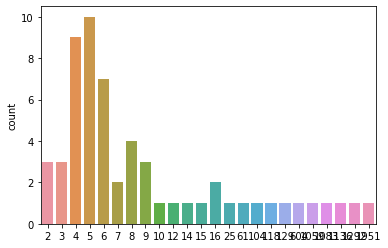

In [17]:
sns.countplot([df[col].nunique() for col in df.columns])

**Checking the distribution of features**

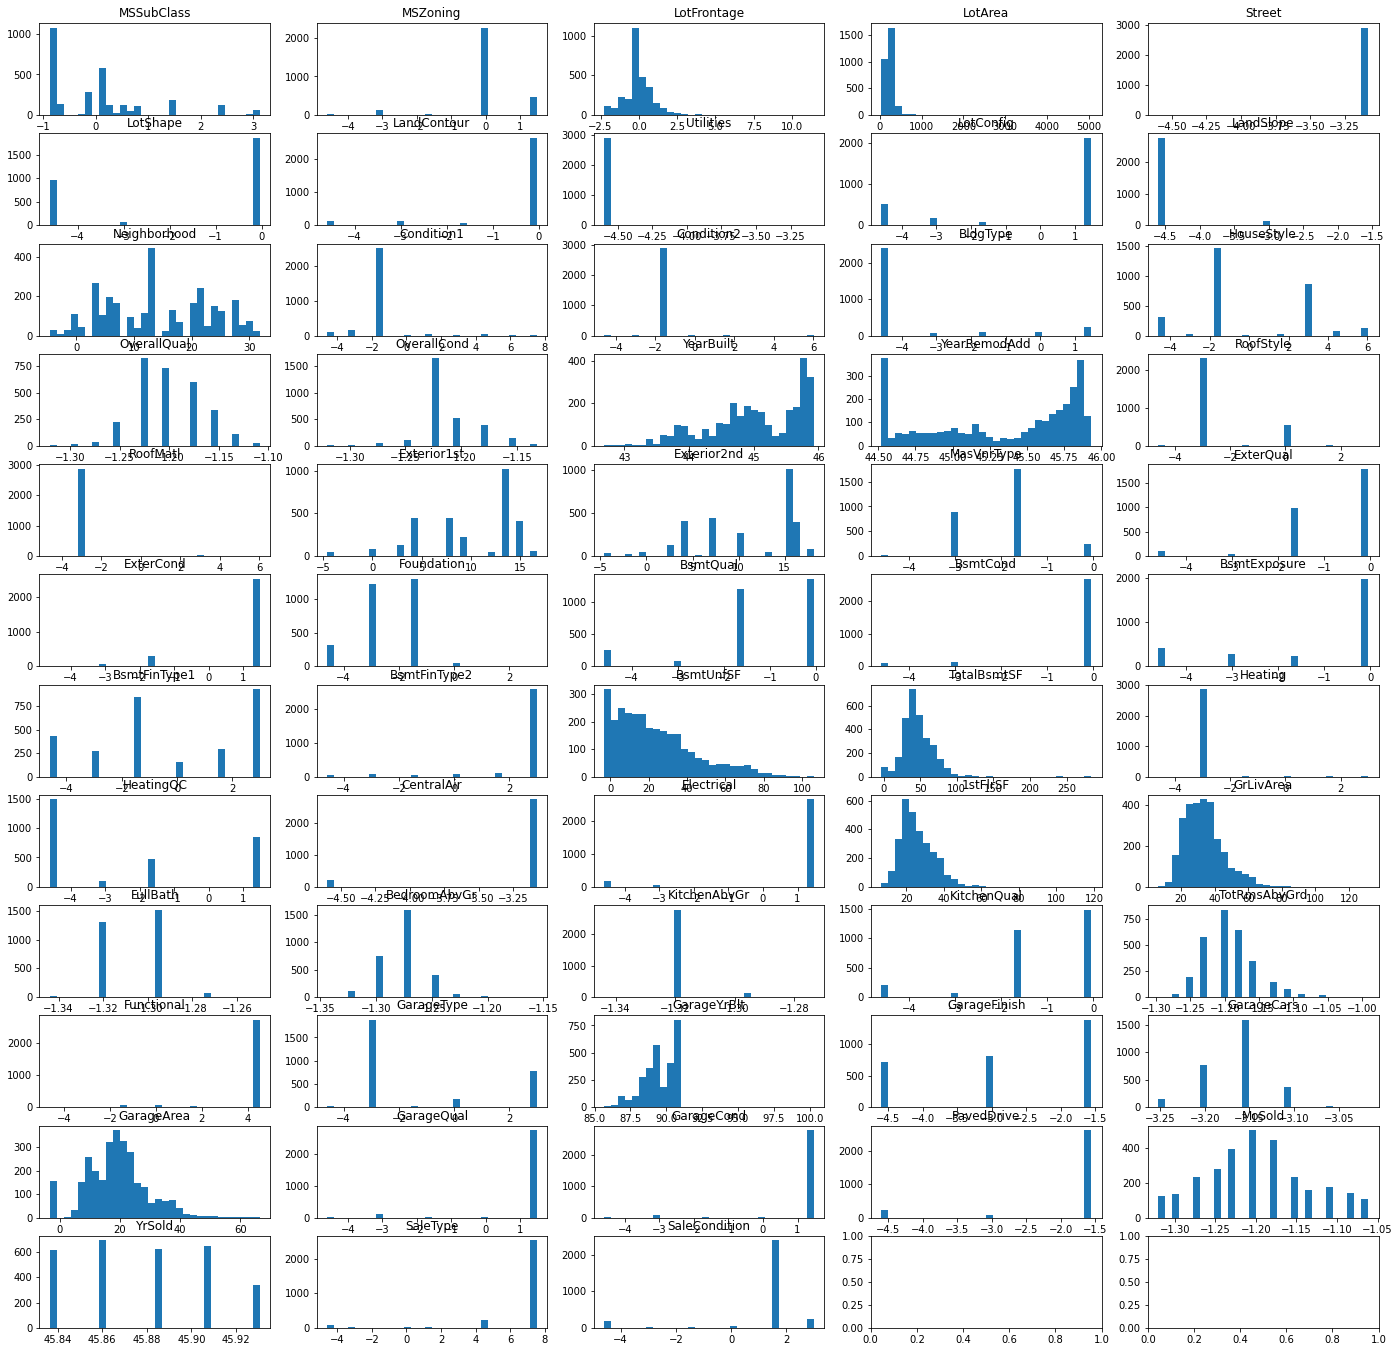

In [18]:
fig,ax = plt.subplots(12,5,figsize=(24,24))

for i in range(df.shape[1]):
    ax.flatten()[i].hist(df.iloc[:,i].to_pandas(),bins=30)
    ax.flatten()[i].set_title(df.columns[i])

In [19]:
df_train=df.iloc[:1460,:]
df_train['SalePrice']=Y
df_test = df.iloc[1460:,:]
df_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0.067320,-0.042149,-0.202033,197.397238,-3.080024,-0.042149,-0.042149,-4.598962,1.476788,-4.598962,...,-3.158066,22.460888,1.476788,1.476788,-1.561087,-1.296820,45.883611,7.552538,1.476788,208500
1,-0.873466,-0.042149,0.501785,224.444843,-3.080024,-0.042149,-0.042149,-4.598962,-1.561087,-4.598962,...,-3.158066,18.331826,1.476788,1.476788,-1.561087,-1.226261,45.860091,7.552538,1.476788,181500
2,0.067320,-0.042149,-0.061269,263.252276,-3.080024,-4.598962,-0.042149,-4.598962,1.476788,-4.598962,...,-3.158066,25.276158,1.476788,1.476788,-1.561087,-1.132183,45.883611,7.552538,1.476788,223500
3,0.302516,-0.042149,-0.436639,223.268860,-3.080024,-4.598962,-0.042149,-4.598962,-4.598962,-4.598962,...,-3.111145,26.871477,1.476788,1.476788,-1.561087,-1.296820,45.836571,7.552538,-4.598962,140000
4,0.067320,-0.042149,0.689469,334.046442,-3.080024,-4.598962,-0.042149,-4.598962,-1.561087,-4.598962,...,-3.111145,35.974182,1.476788,1.476788,-1.561087,-1.061624,45.883611,7.552538,1.476788,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.067320,-0.042149,-0.342796,184.861261,-3.080024,-0.042149,-0.042149,-4.598962,1.476788,-4.598962,...,-3.158066,18.331826,1.476788,1.476788,-1.561087,-1.155702,45.860091,7.552538,1.476788,175000
1456,-0.873466,-0.042149,0.736390,308.527614,-3.080024,-0.042149,-0.042149,-4.598962,1.476788,-4.598962,...,-3.158066,20.208672,1.476788,1.476788,-1.561087,-1.296820,45.930650,7.552538,1.476788,210000
1457,0.302516,-0.042149,-0.155112,211.320874,-3.080024,-0.042149,-0.042149,-4.598962,1.476788,-4.598962,...,-3.204987,8.572224,1.476788,1.476788,-1.561087,-1.226261,45.930650,7.552538,1.476788,266500
1458,-0.873466,-0.042149,-0.061269,227.196642,-3.080024,-0.042149,-0.042149,-4.598962,1.476788,-4.598962,...,-3.204987,8.009170,1.476788,1.476788,-1.561087,-1.249781,45.930650,7.552538,1.476788,142125


## Checking the multicollinearity present in the dataset

<AxesSubplot:>

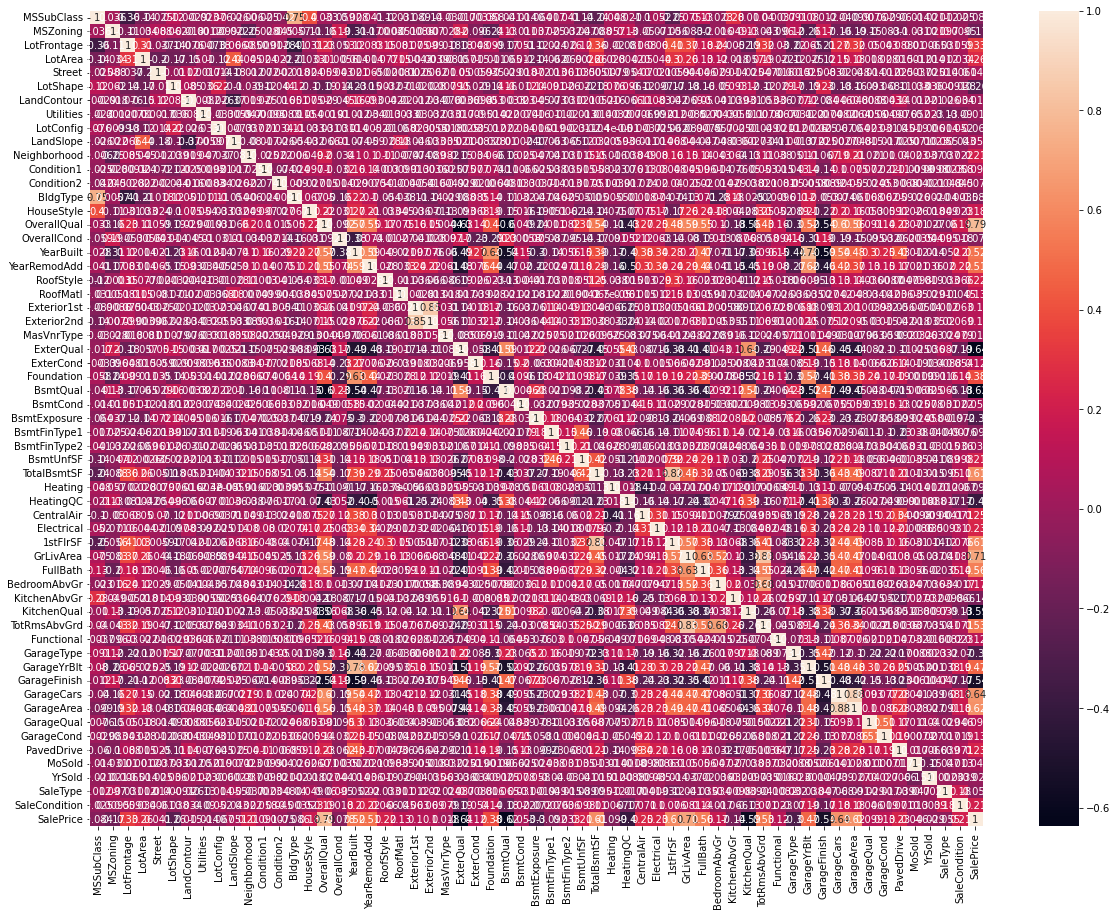

In [20]:
fig=plt.figure()
fig.set_size_inches(20, 15)
sns.heatmap(df_train.to_pandas().corr(),annot=True)

**Some features are highly correlated but most have distribution of mediocre correlation**

(array([  3.,   2.,   0.,   2.,   3.,   7.,   5.,  10.,  39.,  35.,  49.,
        100., 138., 186., 146., 156., 142., 102., 100.,  68.,  52.,  44.,
         22.,  24.,  12.,   4.,   3.,   3.,   1.,   2.]),
 array([10.46024211, 10.56271647, 10.66519084, 10.7676652 , 10.87013956,
        10.97261393, 11.07508829, 11.17756266, 11.28003702, 11.38251138,
        11.48498575, 11.58746011, 11.68993448, 11.79240884, 11.8948832 ,
        11.99735757, 12.09983193, 12.2023063 , 12.30478066, 12.40725502,
        12.50972939, 12.61220375, 12.71467812, 12.81715248, 12.91962684,
        13.02210121, 13.12457557, 13.22704994, 13.3295243 , 13.43199866,
        13.53447303]),
 <BarContainer object of 30 artists>)

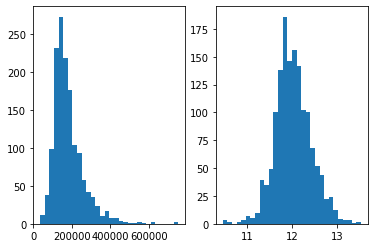

In [21]:
fig,ax = plt.subplots(1,2)
ax[0].hist(df_train.iloc[:,-1].to_pandas(),bins=30)
ax[1].hist(np.log(df_train.iloc[:,-1].to_pandas()),bins=30)

#### THE TARGET SHOWS A VERY CLOSE TO NORMAL DISTRIBUTION UPON LOG TRANSFORMATION. THIS WILL ALSO HANDLE OUTLIERS TO SOME EXTENT

In [22]:
X = df_train.iloc[:,:-1].values
y = cp.log(df_train.iloc[:,-1])
type(X),type(y)

(cupy._core.core.ndarray, cupy._core.core.ndarray)

## HYPERPARAMETERS THAT MAY BE USED FOR HYPERPARAMETER TUNING

In [23]:
params={'fit_intercept':[True,False],
        'algorithm' : ['svd', 'eig', 'qr', 'svd-qr', 'svd-jacobi']
        }
ridge_params={'alpha':[10**(-i) for i in range(0,10)],'fit_intercept':[True,False],
                                  'solver':['eig', 'svd']}
lasso_params={'alpha':[10**(-i) for i in range(0,10)],'fit_intercept':[True,False],
             'tol':[10**(-i) for i in range(2,5)]}
elastic_params={'alpha':[10**(-i) for i in range(-1,5)],
                'fit_intercept':[True,False],
                'l1_ratio':np.arange(0.2,0.9,0.1),
                'tol':[1e-5,1e-4,1e-3]}

#### CHECKING FOR A PRELIMINARY ANALYSIS FOR HOW THE REGRESSORS AND THEIR SOLVERS(IF PRESENT) PERFORM FOR SCORING WITH VARIOUS METRICS

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)
y_train, y_test = y_train.astype('float64'), y_test.astype('float64')

print("Linear Regression")
for algo in params['algorithm']:
    reg=LinearRegression(algorithm=algo)
    reg.fit(X_train,y_train)
    y_pred=reg.predict(X_test)
    print(algo,reg.score(X_test,y_test),r2_score(y_test,y_pred),mean_absolute_error(y_test,y_pred),mean_squared_error(y_test,y_pred))

print('\nRidge')
for algo in ridge_params['solver']:
    
    reg=Ridge(solver=algo)
    reg.fit(X_train,y_train)
    y_pred=reg.predict(X_test)
    print(algo,reg.score(X_test,y_test),r2_score(y_test,y_pred),mean_absolute_error(y_test,y_pred),mean_squared_error(y_test,y_pred))
    
print('\nLasso')
reg=Lasso()
reg.fit(X_train,y_train)
y_pred=reg.predict(X_test)
print(reg.score(X_test,y_test),r2_score(y_test,y_pred),mean_absolute_error(y_test,y_pred),mean_squared_error(y_test,y_pred))

print('\nElasticNet')
reg=ElasticNet()
reg.fit(X_train,y_train)
y_pred=reg.predict(X_test)
print(reg.score(X_test,y_test),r2_score(y_test,y_pred),mean_absolute_error(y_test,y_pred),mean_squared_error(y_test,y_pred))

Linear Regression
svd 0.8785297245823924 0.8785297245823924 0.0999388399848711 0.019515194336489197
eig 0.8785297245825017 0.8785297245825017 0.0999388399848086 0.01951519433647163
qr 0.8785297245824093 0.8785297245824093 0.09993883998486386 0.01951519433648647
svd-qr -0.06130512468485305 -0.06130512468485305 0.3242927640478468 0.17050735817739474
svd-jacobi -0.061305124684885914 -0.061305124684885914 0.32429276404785695 0.17050735817739998

Ridge
eig -0.04577227102835213 -0.04577227102835213 0.31968604080553986 0.16801187805549053
svd -0.04577227102836767 -0.04577227102836767 0.31968604080554414 0.16801187805549309

Lasso
-0.021116891241206304 -0.021116891241206304 0.3147413720729077 0.16405078941605247

ElasticNet
-0.024512006460296387 -0.024512006460296387 0.3151965557643496 0.1645962424749801


#### HERE WE INTEND TO FIND THE BEST AMOUNT OF FEATURES FOR R2 SCORING AND ALSO PICKING THE BEST HYPERPARAMETERS FOR THE SAID FEATURES THAT CAN MAXIMISE THE SCORE ON UNENCOUNTERED DATA. THIS IS AN EXPENSIVE OPERATION
**REGRESSOR USED: Linear Regression**

In [25]:
%%time
MAX_TEST_SCORE=-100
MAX_TRAIN_SCORE=0
MAX_INDEX=-1
for i in range(1,X.shape[1]):
    X = df_train.iloc[:,:-1].values
    y = cp.log(df_train.iloc[:,-1])
    pca = PCA(n_components=i,output_type='cupy')
    pca.fit(X)
    X=pca.transform(X)
    var=pca.explained_variance_ratio_.sum()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)
    y_train, y_test = y_train.astype('float64'), y_test.astype('float64')
    reg=LinearRegression()
    grid = GridSearchCV(estimator=reg,
                       param_grid=params,
                       scoring='r2',
                       cv=5,
    #                    n_jobs=-1,
                       return_train_score=True)
    grid.fit(X_train.get(),y_train.get())
    clear_output()
#     print(i,grid.score(X_test.get(),y_test.get())
    score=grid.score(X_test.get(),y_test.get())
    if score > MAX_TEST_SCORE:
        best_X=X.copy()
        best_y=y.copy()
        MAX_TEST_SCORE = score
        MAX_TRAIN_SCORE=grid.score(X_train.get(),y_train.get())
        MAX_INDEX = i
        BEST_GRID = grid
#         MAX_SCORE = grid.score(X_test,y_test)
#         MAX_INDEX = i
    
print(MAX_TEST_SCORE,MAX_TRAIN_SCORE,MAX_INDEX)

0.8791361771633025 0.8707583883496123 54
CPU times: user 29.6 s, sys: 6.55 s, total: 36.1 s
Wall time: 36.2 s


In [26]:
BEST_GRID.best_params_,BEST_GRID.best_score_,BEST_GRID.score(best_X.get(),best_y.get())

({'algorithm': 'svd', 'fit_intercept': True},
 -12.766079149920769,
 0.8737266765029255)

#### NOW WE USE THE FEATURE SELECTED FEATURES AND THE BEST HYPERPARAMS TO MAKE THE MODEL THAT WILL BEST PREDICT ON THE TEST DATASET

In [27]:
reg=LinearRegression(**BEST_GRID.best_params_)
reg.fit(best_X,best_y)

LinearRegression()

**THE FUNCTION BELOW WILL DO THE FEATURE SELECTION THAT RESULTED IN THE PROCESS OF MAKING BEST MODEL**

In [28]:
# df_test = cd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
df_test=preprocess_df(df_test,cols=MAX_INDEX)

In [29]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,-41.281916,18.707941,-3.152040,-3.399799,1.718229,18.741509,-0.914381,-0.345054,1.961674,-0.157583,...,0.021108,-0.022722,-0.024159,0.027224,-0.012108,0.043758,-0.006236,-0.007416,-0.022971,0.051359
1,-104.733438,3.329145,-7.037611,-13.598404,-0.380177,-2.798260,-10.506767,0.581761,0.038396,2.570327,...,0.015787,-0.032253,0.013516,-0.001119,-0.010120,0.054431,-0.009836,-0.000830,-0.000413,0.010342
2,-93.397782,23.393354,-7.629827,1.826724,-7.187769,1.093155,-4.854677,5.895660,-2.706146,-0.734290,...,0.014673,-0.013846,0.037320,-0.013376,-0.059142,0.046341,-0.010391,0.020913,-0.021368,-0.010637
3,-3.187086,12.048987,-4.119554,3.681989,-7.864221,1.102007,-4.679509,4.535803,-3.876547,-0.405804,...,-0.043916,-0.012178,0.042485,-0.010350,0.004664,0.055924,-0.003942,-0.008257,-0.012360,-0.005934
4,111.983431,-29.942527,4.567381,-2.358644,14.528639,0.428727,7.034891,-1.410319,-3.982021,-0.187103,...,-0.048817,-0.017552,-0.030645,0.015459,-0.118338,0.039338,-0.013842,0.002826,0.020078,0.001088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,187.649926,13.392398,14.612676,-5.905165,0.055824,-13.148299,6.010463,3.962621,-4.663446,-0.548771,...,-0.077897,-0.048454,0.050646,-0.041631,0.006560,-0.038156,-0.018394,-0.014904,-0.044788,0.003754
1455,188.453624,18.828419,2.660245,-0.525187,-0.350889,-3.310716,9.879787,3.628700,0.761015,-0.607514,...,-0.111778,0.003965,0.071097,-0.021967,-0.050171,-0.053054,0.023305,0.008622,-0.021184,0.002860
1456,-238.696685,26.879233,-15.405217,-11.909575,-0.240641,8.098928,-5.678075,3.375702,4.458057,-0.270822,...,0.140228,0.157612,0.110942,0.060624,0.071584,-0.046126,0.015619,-0.021086,-0.013006,0.004464
1457,-13.024746,12.071817,12.295192,-17.101736,1.125090,-9.485577,-6.967968,1.731204,-5.451183,-0.122032,...,-0.081403,0.053226,0.041336,-0.003212,0.025216,-0.022606,0.014520,0.010892,-0.001260,0.014978


In [30]:
ids=cd.Series(df_test.index+1461)
target=reg.predict(df_test.values.get())

## READYING THE SUBMISSION DATAFRAME
**Here we also inverse transformed the target for making the actual predictions**

In [31]:
df=cd.DataFrame()
df['Id']=ids
df['SalePrice']=np.exp(target,dtype='float64')
df

,Id,SalePrice
0,1461,133388.401664
1,1462,129215.522576
2,1463,175420.326780
3,1464,202154.422577
4,1465,242388.875861
...,...,...
1454,2915,135850.661122
1455,2916,135939.237207
1456,2917,111391.860100
1457,2918,106665.165083


In [32]:
pdf=df.to_pandas()

In [33]:
pdf.to_csv('submission.csv',index=False)

# THE ABOVE MODEL LED TO KAGGLE SCORE = 0.29055 AND RANK = 3845

## OPTIONALLY DOING THE ABOVE PROCESS USING REGRESSOR AS ELASTICNET

In [34]:
%%time
MAX_TEST_SCORE=-100
MAX_TRAIN_SCORE=0
MAX_INDEX=-1
for i in range(45,X.shape[1]):
    X = df_train.iloc[:,:-1].values
    y = cp.log(df_train.iloc[:,-1])
    pca = PCA(n_components=i,output_type='cupy')
    pca.fit(X)
    X=pca.transform(X)
    var=pca.explained_variance_ratio_.sum()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)
    y_train, y_test = y_train.astype('float64'), y_test.astype('float64')
    reg=ElasticNet()
    grid = GridSearchCV(estimator=reg,
                       param_grid=elastic_params,
                       scoring='r2',
                       cv=5,
    #                    n_jobs=-1,
                       return_train_score=True,
                       verbose=1)
    grid.fit(X_train.get(),y_train.get())
    clear_output()
#     print(i,grid.score(X_test.get(),y_test.get())
    score=grid.score(X_test.get(),y_test.get())
    if score > MAX_TEST_SCORE:
        best_X=X.copy()
        best_y=y.copy()
        MAX_TEST_SCORE = score
        MAX_TRAIN_SCORE=grid.score(X_train.get(),y_train.get())
        MAX_INDEX = i
        BEST_GRID = grid
#         MAX_SCORE = grid.score(X_test,y_test)
#         MAX_INDEX = i
    
print(MAX_TEST_SCORE,MAX_TRAIN_SCORE,MAX_INDEX)

0.8779021361916294 0.8699948691749199 54
CPU times: user 5min 2s, sys: 7.62 s, total: 5min 10s
Wall time: 5min 11s


In [35]:
BEST_GRID.best_params_,BEST_GRID.best_score_,BEST_GRID.score(best_X.get(),best_y.get())

({'alpha': 0.0001,
  'fit_intercept': True,
  'l1_ratio': 0.8000000000000003,
  'tol': 1e-05},
 0.8145819522977188,
 0.872823508890463)

In [36]:
# df.to_csv('submission.csv',index=False)